# 1. Data & Imports 

In [4]:
# time meausre
import time
import math
start_time = time.time()

def print_time(execution_time):
    hours = int(math.floor(int(execution_time)/3600))
    minutes = int(math.floor((execution_time/3600-hours)*60))
    seconds = execution_time%60
    print("--- Total: %i hours, %i minutes, %f seconds  ---" % (hours,minutes,seconds))

In [5]:
import keras
import autokeras as ak
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


# constants
#path = 'C:/Users/monte/Documents/Memoria/src'
path = 'C:/Users/asus/Documents/2023_2/Memoria/src'


# seeds
global_seed = 19
# np.random.seed(seed=global_seed) # seed gets seted by statement below
keras.utils.set_random_seed(global_seed)
tf.config.experimental.enable_op_determinism()

# Bstar
B_df = pd.read_csv(path+'/Data/b_spectral_lines.csv')
# Observed spectra
Obs_df = pd.read_csv(path+'/Data/observed_spectral_lines_v3.csv')

Using TensorFlow backend


# 2. Data

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

target = ['temperature','g','v']


X = B_df.drop(target,axis = 1)
Y = B_df[target]
X_obs = Obs_df.drop(target+['HD','date','time'],axis=1)
Y_obs = Obs_df[target]

X = np.random.normal(loc=0, scale=0.01, size=X.shape) + X
y_scaler = MinMaxScaler()

x_train, x_val, y_train, y_val = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=global_seed)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, train_size=0.75, test_size=0.25, random_state=global_seed)

#x_train = np.random.normal(loc=0, scale=0.01, size=x_train.shape) + x_train

y_scaler = y_scaler.fit(y_train)
y_train = y_scaler.transform(y_train)
y_val = y_scaler.transform(y_val)
y_test = y_scaler.transform(y_test)
y_obs = y_scaler.transform(Y_obs.values)

formatted_x_train = np.expand_dims(x_train, axis=2) #This step it's very important an CNN will only accept this data shape
formatted_x_val = np.expand_dims(x_val, axis=2)
formatted_x_test = np.expand_dims(x_test, axis=2)
formatted_x_obs = np.expand_dims(X_obs, axis=2)



c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [7]:
# Density plot function

# https://kdepy.readthedocs.io/en/latest/examples.html#minimal-working-example-with-options
from KDEpy import FFTKDE
from sklearn.neighbors import KernelDensity
import numpy as np

measure = ['Temperature','log g', 'v sini']
measure_unit = ['[K]', '[1]', '[km/s]']

def SKL_density_plot(data, ax,low_bound=None,up_bound=None,title='', color='black',alpha=1,label='',kernel='gaussian', bw='silverman',linewidth=1):
  
	if low_bound != None and up_bound != None:
		bw = FFTKDE(bw=bw, kernel='gaussian').fit(data).bw
		kde = KernelDensity(bandwidth=bw, kernel=kernel).fit(data.reshape(-1,1))
		data = np.concatenate((data, 2 * low_bound - data, 2 * up_bound - data))
		kde = KernelDensity(bandwidth=kde.bandwidth_, kernel=kernel).fit(data.reshape(-1,1))
		x = np.linspace(low_bound,up_bound,1000)
		y = np.exp(kde.score_samples(x.reshape(-1,1)))
		plot_y = y[np.where((x>=low_bound) & (x<=up_bound))] # Set the KDE to zero outside of the domain
		plot_x = x[np.where((x>=low_bound) & (x<=up_bound))]  # Set the KDE to zero outside of the domain
		plot_y = plot_y * 3  # Double the y-values to get integral of ~1
		ax.plot(plot_x, plot_y, label=label,color=color,alpha=alpha,linewidth=linewidth)
		return x, y, kde
	else:
		kde = KernelDensity(bandwidth=bw, kernel=kernel).fit(data.reshape(-1,1))
		x=np.linspace(data.min(),data.max(),1000)
		y = np.exp(kde.score_samples(x.reshape(-1,1)))
		ax.plot(x, y, label=label,color=color,alpha=alpha)
		return x, y, kde

# 3. NN Training

In [8]:
from keras_tuner.engine import hyperparameters as hp

# convBlock
conv_kernel_size = hp.Choice("kernel_size", [2,3,5,7],)
conv_num_layers = hp.Choice("conv_layers", [1,2],)
conv_num_blocks = 1
conv_filters = hp.Choice("filters", [128,256],)

# # DenseBlock
dense_num_layers = hp.Choice("dense_layers", [2,3])
dense_units = hp.Choice("dense_units", [128,256])

# RegressionHead
# head_dropout = hp.Float(
#                 'dropout_head',
#                 min_value=0.0,
#                 max_value=0.5,
#                 default=0.25,
#                 step=0.05,
#             )

input = ak.Input()
conv1 = ak.ConvBlock(
  	kernel_size=conv_kernel_size,
  	num_blocks=conv_num_blocks,
  	num_layers=conv_num_layers,
  	filters=conv_filters,
  	max_pooling=True,
		separable=False,
  	#dropout=conv_dropout,
)(input)
conv2 = ak.ConvBlock(
  	kernel_size=conv_kernel_size,
  	num_blocks=conv_num_blocks,
  	num_layers=conv_num_layers,
  	filters=conv_filters,
  	max_pooling=True,
		separable=False,
  	#dropout=conv_dropout,
)(conv1)
dense = ak.DenseBlock(
  	num_layers=dense_num_layers, 
  	num_units=dense_units, 
  	use_batchnorm=False, 
  	#dropout=dense_dropout
)(conv2)
regression_output = ak.RegressionHead(
  	output_dim=3, 
   	loss="mse", 
    metrics=["mae"], 
    #dropout=head_dropout,
)(dense)


def generateAutoModel():
  return ak.AutoModel(
	inputs=input,
	outputs=regression_output,
	max_trials=50,
	loss='mse',
	metrics = 'mae',
	tuner='bayesian',
	overwrite=False,
	seed=global_seed,
	max_model_size=None,
 	project_name='noisy_long_range_unscaled_opt')



In [9]:
# set timer
curr_time = time.time()

In [10]:
# 2hrs 18 min
model = generateAutoModel()
model.fit(formatted_x_train, y_train,validation_data=(formatted_x_val, y_val), epochs=20)


Reloading Tuner from .\noisy_long_range_unscaled_opt\tuner0.json
Epoch 1/20
459/459 [==============================] - 14s 14ms/step - loss: 0.1107 - mae: 0.2746 - val_loss: 0.0685 - val_mae: 0.2196
Epoch 2/20
459/459 [==============================] - 6s 14ms/step - loss: 0.0453 - mae: 0.1637 - val_loss: 0.0182 - val_mae: 0.0908
Epoch 3/20
459/459 [==============================] - 6s 14ms/step - loss: 0.0294 - mae: 0.1292 - val_loss: 0.0101 - val_mae: 0.0675
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.0188 - mae: 0.1038 - val_loss: 0.0063 - val_mae: 0.0564
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.0165 - mae: 0.0974 - val_loss: 0.0050 - val_mae: 0.0498
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.0155 - mae: 0.0935 - val_loss: 0.0083 - val_mae: 0.0631
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.0130 - mae: 0.0866 - val_loss: 0.0072 - val_mae: 0.0634
Epo

INFO:tensorflow:Assets written to: .\noisy_long_range_unscaled_opt\best_model\assets


INFO:tensorflow:Assets written to: .\noisy_long_range_unscaled_opt\best_model\assets


In [11]:
# execution time print
print_time(float(time.time() - curr_time))

--- Total: 0 hours, 2 minutes, 16.095641 seconds  ---


In [12]:
model = generateAutoModel()
model.fit(formatted_x_train, y_train,validation_data=(formatted_x_val, y_val), epochs=30)

Reloading Tuner from .\noisy_long_range_unscaled_opt\tuner0.json
Epoch 1/30
459/459 [==============================] - 8s 14ms/step - loss: 0.1110 - mae: 0.2756 - val_loss: 0.0841 - val_mae: 0.2450
Epoch 2/30
459/459 [==============================] - 6s 14ms/step - loss: 0.0672 - mae: 0.2083 - val_loss: 0.0372 - val_mae: 0.1392
Epoch 3/30
459/459 [==============================] - 6s 14ms/step - loss: 0.0312 - mae: 0.1347 - val_loss: 0.0245 - val_mae: 0.1241
Epoch 4/30
459/459 [==============================] - 6s 14ms/step - loss: 0.0189 - mae: 0.1047 - val_loss: 0.0081 - val_mae: 0.0694
Epoch 5/30
459/459 [==============================] - 6s 13ms/step - loss: 0.0164 - mae: 0.0973 - val_loss: 0.0067 - val_mae: 0.0595
Epoch 6/30
459/459 [==============================] - 6s 14ms/step - loss: 0.0145 - mae: 0.0918 - val_loss: 0.0041 - val_mae: 0.0462
Epoch 7/30
459/459 [==============================] - 6s 14ms/step - loss: 0.0127 - mae: 0.0862 - val_loss: 0.0047 - val_mae: 0.0529
Epoc

INFO:tensorflow:Assets written to: .\noisy_long_range_unscaled_opt\best_model\assets


INFO:tensorflow:Assets written to: .\noisy_long_range_unscaled_opt\best_model\assets


In [13]:
exp = model.export_model()
exp.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 701, 1)]          0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 701, 1)           0         
 t32)                                                            
                                                                 
 conv1d (Conv1D)             (None, 695, 256)          2048      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 115, 256)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 114, 256)          131328    
                                                                 
 conv1d_2 (Conv1D)           (None, 113, 256)          131328

In [14]:
# Evaluate the best model with testing data.
evaluation = model.evaluate(formatted_x_test, y_test)

print('loss: %.5f  MAE:%.5f'% (evaluation[0],evaluation[1]))

153/153 [==============================] - 1s 5ms/step - loss: 0.0017 - mae: 0.0308
loss: 0.00167  MAE:0.03076


In [15]:
predictions = model.predict(formatted_x_test)

153/153 [==============================] - 1s 3ms/step


In [16]:
losses = []
maes = []

for i in range(len(target)):
  losses.append(np.mean((predictions[:,i]-y_test[:,i])**2))
  maes.append(np.mean(np.abs(predictions[:,i]-y_test[:,i])))
  
print('Temperatura - loss: %.6f  MAE:%.4f'% (losses[0],maes[0]))
print('log g -       loss: %.6f  MAE:%.4f'% (losses[1],maes[1]))
print('v -           loss: %.6f  MAE:%.4f'% (losses[2],maes[2]))


Temperatura - loss: 0.002558  MAE:0.0382
log g -       loss: 0.001497  MAE:0.0299
v -           loss: 0.000961  MAE:0.0241


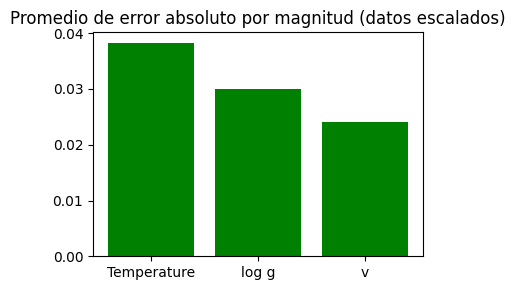

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,3))
x_data = ['Temperature','log g','v']

diff = np.mean(np.abs(predictions-y_test),axis=0)
axes.bar(x_data,diff, color='green')
axes.set_title('Promedio de error absoluto por magnitud (datos escalados)')
plt.tight_layout();
plt.show()


In [18]:
predictions = y_scaler.inverse_transform(predictions)

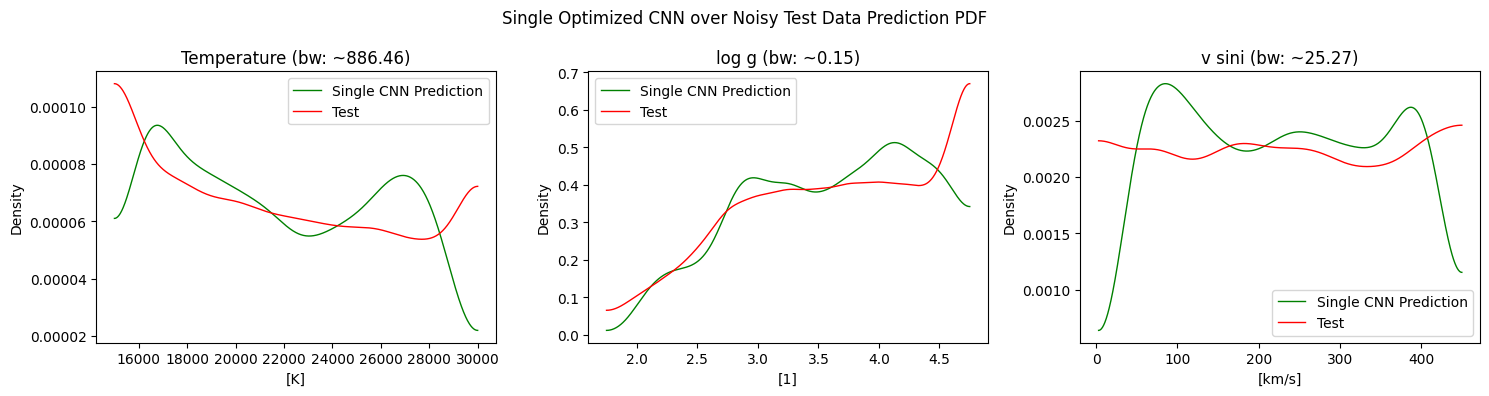

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

for i, featureName in enumerate(target):
	x, y, kde = SKL_density_plot(predictions[:,i], axes[i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'green',label='Single CNN Prediction')
	x, y, kde = SKL_density_plot(y_scaler.inverse_transform(y_test)[:,i], axes[i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color='red',label='Test')
	axes[i].set_xlabel(measure_unit[i])
	axes[i].set_ylabel('Density')
	axes[i].set_title(measure[i]+' (bw: ~%.2f'%(kde.bandwidth_)+')')
	axes[i].legend()

plt.suptitle('Single Optimized CNN over Noisy Test Data Prediction PDF')
plt.legend()
plt.tight_layout();
plt.show()

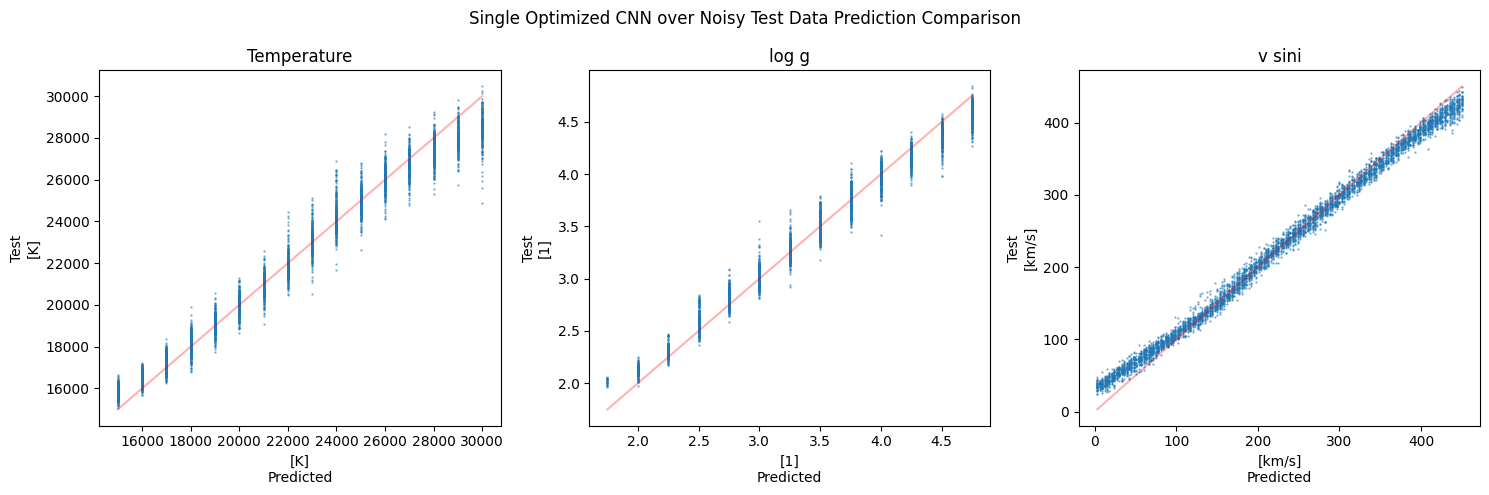

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for i, featureName in enumerate(target):
	x_space = np.linspace(y_scaler.inverse_transform(y_test)[:,i].min(), y_scaler.inverse_transform(y_test)[:,i].max(), 100)
	axes[i].scatter(x=y_scaler.inverse_transform(y_test)[:,i],y=predictions[:,i],s=0.5,alpha=0.5)
	axes[i].plot(x_space,x_space,c='red',alpha=0.3)
	axes[i].set_xlabel(measure_unit[i]+'\nPredicted')
	axes[i].set_ylabel('Test\n'+measure_unit[i])
	axes[i].set_title(measure[i])
 
plt.suptitle('Single Optimized CNN over Noisy Test Data Prediction Comparison')
plt.tight_layout();
plt.show()

In [21]:
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,3))
# x_data = ['Temperature','log g','v']
# 
# diff = np.mean(np.abs(y_scaler.transform(predictions)-y_test),axis=0)
# axes.bar(x_data,diff, color='green')
# axes.set_title('Promedio de error absoluto por magnitud (datos escalados)')
# plt.tight_layout();
# plt.show()


## Resultados datos de testing

In [22]:
#data formatting
inverse_y_test = y_scaler.inverse_transform(y_test)
rel_error = np.abs(predictions-inverse_y_test)*(1/inverse_y_test)*100
abs_error = np.abs(predictions-inverse_y_test)

table_formatted_temperature = [str(round(i)) for i in np.round(inverse_y_test[:,0],0)]
table_formatted_log_g = [str(round(i,2)) for i in np.round(inverse_y_test[:,1],2)]
table_formatted_v = [str(round(i)) for i in np.round(inverse_y_test[:,2],0)]

table_formatted_temperature_pred = [str(round(i)) for i in predictions[:,0]]
table_formatted_log_g_pred = [str(round(i,2)) for i in predictions[:,1]]
table_formatted_v_pred = [str(round(i)) for i in predictions[:,2]]

table_formatted_temperature_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,0],rel_error[:,0])]
table_formatted_log_g_error = [str(round(i,2))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,1],rel_error[:,1])]
table_formatted_v_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,2],rel_error[:,2])]

In [23]:
# table plot
results = pd.DataFrame({
  'Temperatura':table_formatted_temperature,'Prediccion_Temp':table_formatted_temperature_pred,'Temp_Error_Abs(Rel)':table_formatted_temperature_error,
  'log_g':table_formatted_log_g,'Prediccion_log_g':table_formatted_log_g_pred,'log_g_Error_Abs(Rel)':table_formatted_log_g_error,
  'v':table_formatted_v,'Prediccion_v':table_formatted_v_pred,'v_Error_Abs(Rel)':table_formatted_v_error,

                    })
results.head(20)

,Temperatura,Prediccion_Temp,Temp_Error_Abs(Rel),log_g,Prediccion_log_g,log_g_Error_Abs(Rel),v,Prediccion_v,v_Error_Abs(Rel)
0,17000,17233,233 (1.4%),3.25,3.1,0.15 (4.7%),246,246,0 (0.2%)
1,18000,18007,7 (0.0%),2.75,2.82,0.07 (2.6%),285,282,3 (1.1%)
2,30000,28345,1655 (5.5%),3.75,3.51,0.24 (6.5%),267,264,3 (1.2%)
3,23000,23698,698 (3.0%),2.5,2.77,0.27 (10.9%),63,82,19 (30.6%)
4,19000,19199,199 (1.0%),3.0,3.06,0.06 (2.0%),126,120,6 (4.9%)
5,17000,17432,432 (2.5%),4.5,4.34,0.16 (3.5%),156,175,19 (12.4%)
6,28000,26766,1234 (4.4%),3.25,3.15,0.1 (2.9%),450,425,25 (5.7%)
7,22000,21571,429 (2.0%),4.0,3.97,0.03 (0.7%),285,284,1 (0.5%)
8,23000,23093,93 (0.4%),3.0,3.01,0.01 (0.4%),30,62,32 (106.0%)
9,23000,22743,257 (1.1%),4.5,4.45,0.05 (1.1%),153,147,6 (3.8%)


## Datos Observados

In [24]:
predictions = model.predict(formatted_x_obs)

8/8 [==============================] - 0s 6ms/step


In [25]:
losses = []
maes = []

for i in range(len(target)):
  losses.append(np.mean((predictions[:,i]-y_obs[:,i])**2))
  maes.append(np.mean(np.abs(predictions[:,i]-y_obs[:,i])))
  
print('Temperatura - loss: %.3f  MAE:%.3f'% (losses[0],maes[0]))
print('log g -       loss: %.3f  MAE:%.3f'% (losses[1],maes[1]))
print('v -           loss: %.3f  MAE:%.3f'% (losses[2],maes[2]))


Temperatura - loss: 0.118  MAE:0.254
log g -       loss: 0.028  MAE:0.128
v -           loss: 0.023  MAE:0.107


In [26]:
#predictions = y_scaler.inverse_transform(predictions)

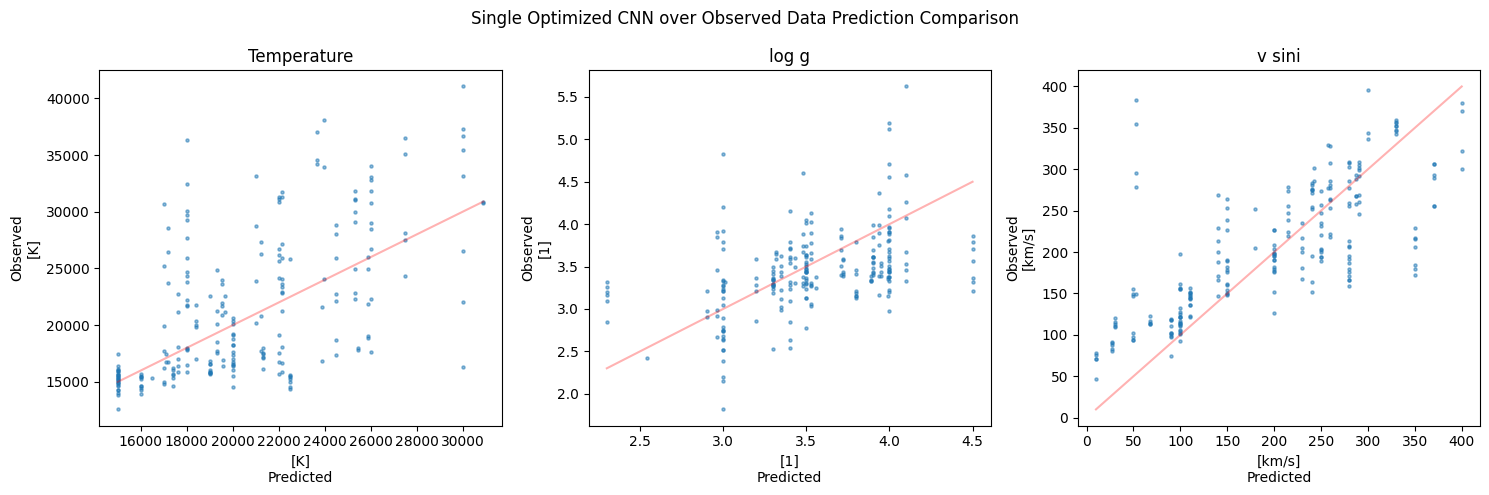

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for i, featureName in enumerate(target):
	x_space = np.linspace(y_scaler.inverse_transform(y_obs)[:,i].min(), y_scaler.inverse_transform(y_obs)[:,i].max(), 100)
	axes[i].scatter(x=y_scaler.inverse_transform(y_obs)[:,i],y=y_scaler.inverse_transform(predictions)[:,i],s=5,alpha=0.5)
	axes[i].plot(x_space,x_space,c='red',alpha=0.3)
	axes[i].set_xlabel(measure_unit[i]+'\nPredicted')
	axes[i].set_ylabel('Observed\n'+measure_unit[i])
	axes[i].set_title(measure[i])
 
plt.suptitle('Single Optimized CNN over Observed Data Prediction Comparison')
plt.tight_layout();
plt.show()

In [28]:
# xi
def xi(obs,sint):
  return np.sum((obs - sint)**2/sint)
def get_closest_spectra_line(index):
  obs = X_obs[index]
  min_dist = np.inf
  min_dist_index = -1
  for i, sint in enumerate(x):
    
    d = xi(obs, sint)
    if d < min_dist:
      min_dist = d
      min_dist_index = i
      
  return min_dist, min_dist_index

In [29]:
# find closest parameters
import numpy as np
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx
  
nearest = []
for obs_parameters in Y_obs.to_numpy():
	neighbor = []
	for param_index in range(len(target)):
		v, _ = find_nearest(Y.iloc[:,param_index].values,obs_parameters[param_index])
		neighbor.append(v)
	nearest.append(neighbor)
 
nearest_index = []
for neighbor in nearest:
	nearest_index.append(Y[(Y.temperature == neighbor[0]) & (Y.g == neighbor[1]) & (Y.v == neighbor[2])].index[0])

In [30]:
#data formatting
inverse_y_obs = y_scaler.inverse_transform(y_obs)
rel_error = np.abs(predictions-inverse_y_obs)*(1/inverse_y_obs)*100
abs_error = np.abs(predictions-inverse_y_obs)
#close = np.array([get_closest_spectra_line(index) for index in range(len(X_obs))])[:,0]

table_formatted_temperature = [str(round(i)) for i in np.round(inverse_y_obs[:,0],0)]
table_formatted_log_g = [str(round(i,2)) for i in np.round(inverse_y_obs[:,1],2)]
table_formatted_v = [str(round(i)) for i in np.round(inverse_y_obs[:,2],0)]

table_formatted_temperature_pred = [str(round(i)) for i in predictions[:,0]]
table_formatted_log_g_pred = [str(round(i,2)) for i in predictions[:,1]]
table_formatted_v_pred = [str(round(i)) for i in predictions[:,2]]

table_formatted_temperature_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,0],rel_error[:,0])]
table_formatted_log_g_error = [str(round(i,2))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,1],rel_error[:,1])]
table_formatted_v_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,2],rel_error[:,2])]

# xi es la distancia entre el espectro observado y el espectro sintetico que tiene parámetros más cercanos a la estrella
table_formatted_xi = [xi(obs,sint) for obs, sint in zip(X_obs,X.iloc[nearest_index].to_numpy())]


UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U8'), dtype('float64')) -> None

In [ ]:
# tabla de resultados modelo unico sobre datos observados

results = pd.DataFrame({
  'Temperatura':table_formatted_temperature,'Prediccion_Temp':table_formatted_temperature_pred,'Temp_Error_Abs(Rel)':table_formatted_temperature_error,
  'log_g':table_formatted_log_g,'Prediccion_log_g':table_formatted_log_g_pred,'log_g_Error_Abs(Rel)':table_formatted_log_g_error,
  'v':table_formatted_v,'Prediccion_v':table_formatted_v_pred,'v_Error_Abs(Rel)':table_formatted_v_error,
  'paramCloseXi': table_formatted_xi
                    })
Obs_df[['HD','date','time']].join(results).set_index('HD').head(60)

,date,time,Temperatura,Prediccion_Temp,Temp_Error_Abs(Rel),log_g,Prediccion_log_g,log_g_Error_Abs(Rel),v,Prediccion_v,v_Error_Abs(Rel),paramCloseXi
HD,,,,,,,,,,,,
33328,2012-11-13,05-37-18,19526,2,19524 (100.0%),3.3,0.98,2.32 (70.3%),287,1,286 (99.8%),122.080146
33328,2013-01-18,03-39-09,19526,2,19524 (100.0%),3.3,0.97,2.33 (70.5%),287,1,286 (99.8%),127.894592
33328,2013-02-26,00-55-34,19526,2,19524 (100.0%),3.3,0.97,2.33 (70.5%),287,1,286 (99.8%),131.462970
33328,2015-02-25,23-58-07,19526,2,19524 (100.0%),3.3,0.99,2.31 (70.1%),287,1,286 (99.8%),139.452009
33328,2015-02-26,00-19-03,19526,2,19524 (100.0%),3.3,0.99,2.31 (70.1%),287,1,286 (99.8%),147.740116
35165,2014-03-20,23-53-54,17000,2,16998 (100.0%),4.0,0.99,3.01 (75.1%),240,1,239 (99.7%),528.961274
35165,2014-03-21,00-14-49,17000,2,16998 (100.0%),4.0,1.0,3.0 (75.0%),240,1,239 (99.7%),622.955257
35165,2014-03-21,00-35-18,17000,2,16998 (100.0%),4.0,1.0,3.0 (75.0%),240,1,239 (99.7%),694.500975
35165,2015-11-14,04-22-43,17000,2,16998 (100.0%),4.0,1.02,2.98 (74.6%),240,1,239 (99.7%),605.805992


# 4. Ensemble

In [ ]:
import time
# time meausre
import time
import math
start_time = time.time()

def print_time(execution_time):
    hours = int(math.floor(int(execution_time)/3600))
    minutes = int(math.floor((execution_time/3600-hours)*60))
    seconds = execution_time%60
    print("--- Total: %i hours, %i minutes, %f seconds  ---" % (hours,minutes,seconds))

# set timer
curr_time = time.time()

In [ ]:

import os

i_fp = open('noisy_data_predictions/weights.txt','w')
i_fp.close()

NUM_MODELS = 10
for i in range(NUM_MODELS):
    i_fp = open('iteration.txt','w')
    i_fp.write(str(i))
    i_fp.close()
    os.system('''cd C:/Users/Asus/Documents/2023_2/Memoria & ./py310_tf/Scripts/activate.ps1 & cd src/2.1.parametersPredictionWorkflow & python noisy_data_model_train.py''')


In [ ]:
# execution time print
print_time(float(time.time() - curr_time))

--- Total: 0 hours, 23 minutes, 57.559891 seconds  ---


### Datos de testing vs prediccion(ensamble)

In [ ]:
# write & read predictions functions
import numpy as np
        
def read_predictions(fp,num_predictions):
    predictions = []
    lines = fp.readlines()
    for i in range(num_predictions):
        t, g, v = lines[i].split()
        predictions.append([float(t),float(g),float(v)])
    return np.array(predictions)

In [ ]:
weights_fp = open('./noisy_data_predictions/weights.txt','r')
weights = []
predictions = []
for i in range(NUM_MODELS):
    weights.append([1-float(weights_fp.readline().split()[0])])
    test_predictions_fp = open('./noisy_data_predictions/test/'+str(i)+'.predictions.txt','r')
    predictions.append(y_scaler.inverse_transform(read_predictions(test_predictions_fp,len(x_test))))

weights = np.array(weights)
predictions = np.array(predictions)#.reshape((NUM_MODELS, len(x_test),len(target)))

In [ ]:
# prediccion del ensamble e incerteza
weights = [(weight)/sum(weights) for weight in weights]

ensemble_prediction = sum([predictions[i]*weights[i] for i in range(NUM_MODELS)])
uncertainty = sum([(ensemble_prediction-predictions[i])**2*weights[i] for i in range(NUM_MODELS)])**(1/2)


In [ ]:
# metricas por parametro

losses = []
maes = []

for i in range(len(target)):
  losses.append(np.mean((y_scaler.transform(ensemble_prediction)[:,i]-y_test[:,i])**2))
  maes.append(np.mean(np.abs(y_scaler.transform(ensemble_prediction)[:,i]-y_test[:,i])))
  
print('Temperatura - loss: %.4f  MAE:%.3f'% (losses[0],maes[0]))
print('log g -       loss: %.4f  MAE:%.3f'% (losses[1],maes[1]))
print('v -           loss: %.4f  MAE:%.3f'% (losses[2],maes[2]))


Temperatura - loss: 0.0012  MAE:0.024
log g -       loss: 0.0005  MAE:0.016
v -           loss: 0.0002  MAE:0.010


c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.w

c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


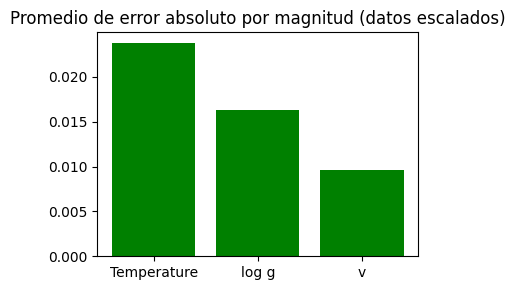

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,3))
x_data = ['Temperature','log g','v']

diff = np.mean(np.abs(y_scaler.transform(ensemble_prediction)-y_test),axis=0)
axes.bar(x_data,diff, color='green')
axes.set_title('Promedio de error absoluto por magnitud (datos escalados)')
plt.tight_layout();
plt.show()


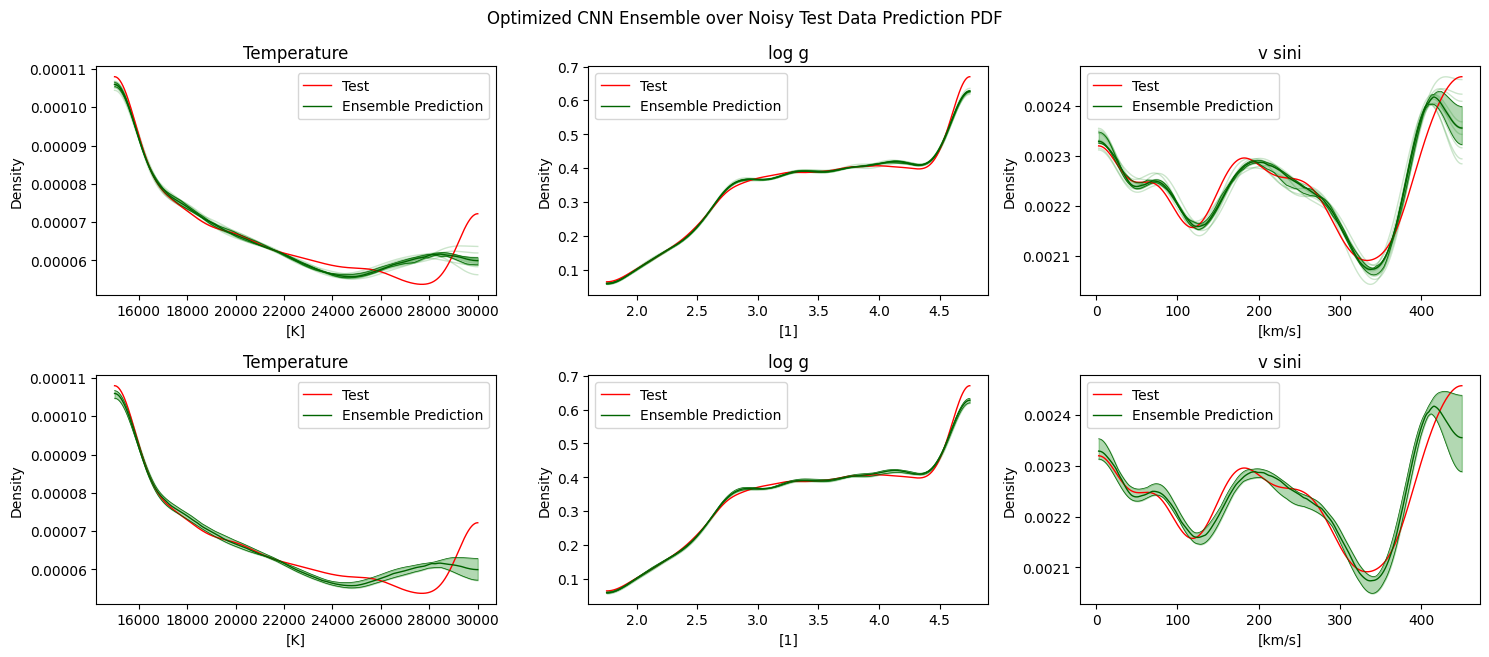

In [ ]:
# Ref: https://stackoverflow.com/questions/60130503/plotting-bars-hist-and-pdf-line-via-kdeplot
import scipy.stats as st
from scipy.interpolate import interp1d

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,6.66))

for i, featureName in enumerate(target):
	x_space = np.linspace(Y[featureName].min(), Y[featureName].max(), 2**12)
	heights = []
	for j in range(NUM_MODELS):
		prediction_y = predictions[j,:,i] # your data goes here
		x,y,prediction_kde = SKL_density_plot(prediction_y, axes[0,i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'green',alpha=0.2)
		f = interp1d(x, y, kind="linear", assume_sorted=True)
		h = f(x_space)*3
		heights.append(h)
  
	heights = np.array(heights)
 
	rescaled_y = y_scaler.inverse_transform(y_test)[:,i]
	x,y,test_kde = SKL_density_plot(rescaled_y, axes[0,i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'red',label='Test')
	x,y,test_kde = SKL_density_plot(rescaled_y, axes[1,i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'red',label='Test')
	f = interp1d(x, y, kind="linear", assume_sorted=True)
	test_h = f(x_space)
 
	# cuantiles 50% de los datos
	q25 = np.quantile(heights,0.25,axis=0)
	q75 = np.quantile(heights,0.75,axis=0)
	axes[0,i].plot(x_space, np.median(heights,axis=0),color='darkGreen',alpha=1,linewidth=1,label='Ensemble Prediction')
	axes[0,i].plot(x_space, q25,color='darkGreen',alpha=1,linewidth=0.5)
	axes[0,i].plot(x_space, q75,color='darkGreen',alpha=1,linewidth=0.5)
	axes[0,i].fill_between(x_space, q25,q75, alpha=0.30, color='green')
	
	# cuantiles 95% de los datos
	q5 = np.quantile(heights,0.05,axis=0)
	q95 = np.quantile(heights,0.95,axis=0)
	axes[1,i].plot(x_space, np.median(heights,axis=0),color='darkGreen',alpha=1,linewidth=1,label='Ensemble Prediction')
	axes[1,i].plot(x_space, q5,color='darkGreen',alpha=1,linewidth=0.5)
	axes[1,i].plot(x_space, q95,color='darkGreen',alpha=1,linewidth=0.5)
	axes[1,i].fill_between(x_space, q5,q95, alpha=0.30, color='green')

	axes[1,i].set_xlabel(measure_unit[i])
	axes[1,i].set_ylabel('Density')
	axes[1,i].legend()
	axes[1,i].set_title(measure[i])

	axes[0,i].set_xlabel(measure_unit[i])
	axes[0,i].set_ylabel('Density')
	axes[0,i].legend()
	axes[0,i].set_title(measure[i])

plt.suptitle('Optimized CNN Ensemble over Noisy Test Data Prediction PDF')
plt.tight_layout()
plt.show()

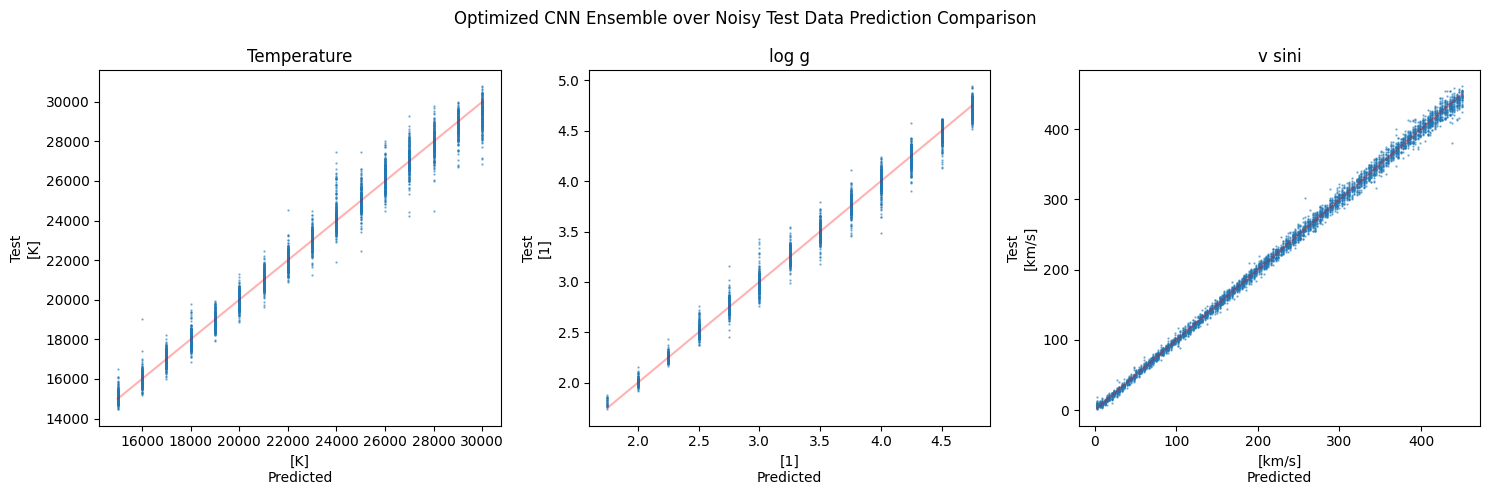

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for i, featureName in enumerate(target):
	x_space = np.linspace(y_scaler.inverse_transform(y_test)[:,i].min(), y_scaler.inverse_transform(y_test)[:,i].max(), 100)
	axes[i].scatter(x=y_scaler.inverse_transform(y_test)[:,i],y=ensemble_prediction[:,i],s=0.5,alpha=0.5)
	axes[i].plot(x_space,x_space,c='red',alpha=0.3)
	axes[i].set_xlabel(measure_unit[i]+'\nPredicted')
	axes[i].set_ylabel('Test\n'+measure_unit[i])
	axes[i].set_title(measure[i])
 
plt.suptitle('Optimized CNN Ensemble over Noisy Test Data Prediction Comparison')
plt.tight_layout();
plt.show()

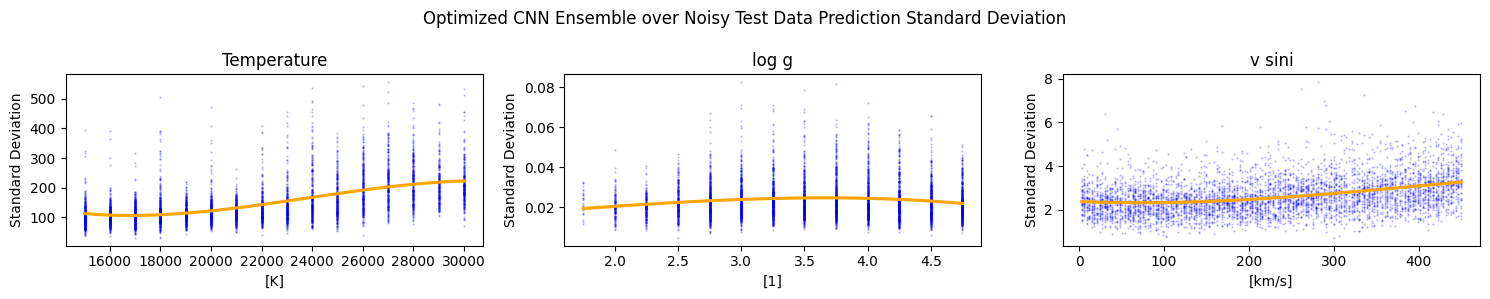

In [ ]:
# dataframe
inverse_y_test = y_scaler.inverse_transform(y_test)
results = pd.DataFrame({
  'Temperatura':inverse_y_test[:,0],'Temp_pred':ensemble_prediction[:,0],'Temp_Variance':uncertainty[:,0],
  'log_g':inverse_y_test[:,1],'log_g_pred':ensemble_prediction[:,1],'log_g_Variance':uncertainty[:,1],
  'v':inverse_y_test[:,2],'v_pred':ensemble_prediction[:,2],'v_Variance':uncertainty[:,2]
                    })
# TODO: algo que permita ver el tamano de las varianzas sobre target feature
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
feat=['Temperatura', 'log_g',	'v']
vari=['Temp_Variance','log_g_Variance','v_Variance']

for i, featureName in enumerate(target):
	x_data = y_scaler.inverse_transform(y_test)[:,i]
	y_data = uncertainty[:,i]
	sns.regplot(x=feat[i], y=vari[i], data=results,ax=axes[i],scatter_kws=dict(alpha=0.2,color='blue',s=0.5),line_kws=dict(color='orange'), order=3);
	axes[i].set_xlabel(measure_unit[i])
	axes[i].set_ylabel("Standard Deviation")
	axes[i].set_title(measure[i])
	#axes[i].legend()

plt.suptitle('Optimized CNN Ensemble over Noisy Test Data Prediction Standard Deviation')
plt.tight_layout()
plt.show()

In [ ]:
# data processing for formatted table

# error sign: ±

table_formatted_temperature_pred = [str(round(i))+' ± '+str(round(j)) for i,j in zip(ensemble_prediction[:,0],uncertainty[:,0])]
table_formatted_log_g_pred = [str(round(i,2))+' ± '+str(round(j,2)) for i,j in zip(ensemble_prediction[:,1],uncertainty[:,1])]
table_formatted_v_pred = [str(round(i))+' ± '+str(round(j)) for i,j in zip(ensemble_prediction[:,2],uncertainty[:,2])]

#data formatting
inverse_y_test = y_scaler.inverse_transform(y_test)
rel_error = np.abs(ensemble_prediction-inverse_y_test)*(1/inverse_y_test)*100
abs_error = np.abs(ensemble_prediction-inverse_y_test)

table_formatted_temperature = [str(round(i)) for i in np.round(inverse_y_test[:,0],0)]
table_formatted_log_g = [str(round(i,2)) for i in np.round(inverse_y_test[:,1],2)]
table_formatted_v = [str(round(i)) for i in np.round(inverse_y_test[:,2],0)]

table_formatted_temperature_error = [str(np.round(i))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,0],rel_error[:,0])]
table_formatted_log_g_error = [str(np.round(i,2))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,1],rel_error[:,1])]
table_formatted_v_error = [str(np.round(i))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,2],rel_error[:,2])]

In [ ]:
# dataframe comparativo de datos de testing

results = pd.DataFrame({
  'Temperatura':table_formatted_temperature,'Prediccion_Temperatura':table_formatted_temperature_pred,'Temp_Error_Abs(Rel)':table_formatted_temperature_error,
  'log_g':table_formatted_log_g,'Prediccion_log_g':table_formatted_log_g_pred,'log_g_Error_Abs(Rel)':table_formatted_log_g_error,
  'v':table_formatted_v,'Prediccion_v':table_formatted_v_pred,'v_Error_Abs(Rel)':table_formatted_v_error,
                    })
results.head(20)

,Temperatura,Prediccion_Temperatura,Temp_Error_Abs(Rel),log_g,Prediccion_log_g,log_g_Error_Abs(Rel),v,Prediccion_v,v_Error_Abs(Rel)
0,17000,17495 ± 128,495.0 (2.9%),3.25,3.18 ± 0.02,0.07 (2.2%),246,244 ± 3,2.0 (0.7%)
1,18000,18323 ± 81,323.0 (1.8%),2.75,2.77 ± 0.02,0.02 (0.6%),285,280 ± 3,5.0 (1.9%)
2,30000,30259 ± 165,259.0 (0.9%),3.75,3.75 ± 0.01,0.0 (0.1%),267,266 ± 3,1.0 (0.6%)
3,23000,23626 ± 251,626.0 (2.7%),2.5,2.56 ± 0.03,0.06 (2.3%),63,67 ± 3,4.0 (6.5%)
4,19000,19267 ± 90,267.0 (1.4%),3.0,3.02 ± 0.01,0.02 (0.7%),126,123 ± 3,3.0 (2.5%)
5,17000,17092 ± 65,92.0 (0.5%),4.5,4.55 ± 0.02,0.05 (1.0%),156,163 ± 3,7.0 (4.2%)
6,28000,27588 ± 213,412.0 (1.5%),3.25,3.21 ± 0.04,0.04 (1.4%),450,445 ± 4,5.0 (1.1%)
7,22000,21082 ± 103,918.0 (4.2%),4.0,3.95 ± 0.02,0.05 (1.3%),285,292 ± 2,7.0 (2.3%)
8,23000,23149 ± 135,149.0 (0.6%),3.0,3.01 ± 0.02,0.01 (0.3%),30,28 ± 2,2.0 (7.6%)
9,23000,23130 ± 134,130.0 (0.6%),4.5,4.55 ± 0.02,0.05 (1.1%),153,151 ± 2,2.0 (1.4%)


# Espectro Observado

In [50]:
weights_fp = open('./noisy_data_predictions/weights.txt','r')
weights = []
predictions = []
for i in range(NUM_MODELS):
    weights.append([1-float(weights_fp.readline().split()[0])])
    test_predictions_fp = open('./noisy_data_predictions/obs/'+str(i)+'.predictions.txt','r')
    predictions.append(y_scaler.inverse_transform(read_predictions(test_predictions_fp,len(X_obs))))

weights = np.array(weights)
predictions = np.array(predictions)#.reshape((NUM_MODELS, len(x_test),len(target)))

In [51]:
# prediccion del ensamble e incerteza
weights = [(weight)/sum(weights) for weight in weights]

ensemble_prediction = sum([predictions[i]*weights[i] for i in range(NUM_MODELS)])
uncertainty = sum([(ensemble_prediction-predictions[i])**2*weights[i] for i in range(NUM_MODELS)])**(1/2)

In [57]:
# metricas por parametro
losses = []
maes = []

for i in range(len(target)):
  losses.append(np.mean((y_scaler.transform(ensemble_prediction)[:,i]-y_obs[:,i])**2))
  maes.append(np.mean(np.abs(y_scaler.transform(ensemble_prediction)[:,i]-y_obs[:,i])))
  
print('Temperatura - loss: %.3f  MAE:%.3f'% (losses[0],maes[0]))
print('log g -       loss: %.3f  MAE:%.3f'% (losses[1],maes[1]))
print('v -           loss: %.3f  MAE:%.3f'% (losses[2],maes[2]))


Temperatura - loss: 2.020  MAE:1.400
log g -       loss: 0.074  MAE:0.243
v -           loss: 0.132  MAE:0.295


c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.w

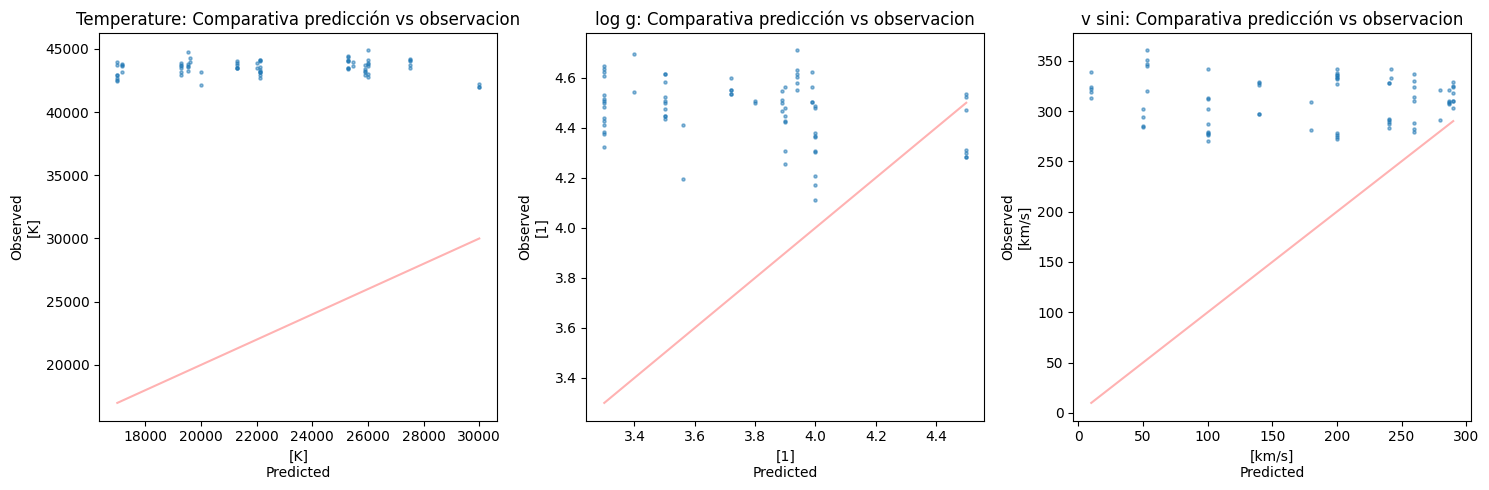

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for i, featureName in enumerate(target):
	x_space = np.linspace(y_scaler.inverse_transform(y_obs)[:,i].min(), y_scaler.inverse_transform(y_obs)[:,i].max(), 100)
	axes[i].scatter(x=y_scaler.inverse_transform(y_obs)[:,i],y=ensemble_prediction[:,i],s=5,alpha=0.5)
	axes[i].plot(x_space,x_space,c='red',alpha=0.3)
	axes[i].set_xlabel(measure_unit[i]+'\nPredicted')
	axes[i].set_ylabel('Observed\n'+measure_unit[i])
	axes[i].set_title(measure[i]+': Comparativa predicción vs observacion')
 
plt.tight_layout();
plt.show()

In [54]:
# data processing for formatted table

# error sign: ±

table_formatted_temperature_pred = [str(round(i))+' ± '+str(round(j)) for i,j in zip(ensemble_prediction[:,0],uncertainty[:,0])]
table_formatted_log_g_pred = [str(round(i,2))+' ± '+str(round(j,2)) for i,j in zip(ensemble_prediction[:,1],uncertainty[:,1])]
table_formatted_v_pred = [str(round(i))+' ± '+str(round(j)) for i,j in zip(ensemble_prediction[:,2],uncertainty[:,2])]

#data formatting
inverse_y_obs = y_scaler.inverse_transform(y_obs)
rel_error = np.abs(ensemble_prediction-inverse_y_obs)*(1/inverse_y_obs)*100
abs_error = np.abs(ensemble_prediction-inverse_y_obs)

table_formatted_temperature = [str(round(i)) for i in np.round(inverse_y_obs[:,0],0)]
table_formatted_log_g = [str(round(i,2)) for i in np.round(inverse_y_obs[:,1],2)]
table_formatted_v = [str(round(i)) for i in np.round(inverse_y_obs[:,2],0)]

table_formatted_temperature_error = [str(np.round(i))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,0],rel_error[:,0])]
table_formatted_log_g_error = [str(np.round(i,2))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,1],rel_error[:,1])]
table_formatted_v_error = [str(np.round(i))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,2],rel_error[:,2])]

In [55]:
# dataframe comparativo de datos observados
inverse_y_obs = y_scaler.inverse_transform(y_obs)
results = pd.DataFrame({
  'Temperatura':table_formatted_temperature,'Prediccion_Temperatura':table_formatted_temperature_pred,'Temp_Error_Abs(Rel)':table_formatted_temperature_error,
  'log_g':table_formatted_log_g,'Prediccion_log_g':table_formatted_log_g_pred,'log_g_Error_Abs(Rel)':table_formatted_log_g_error,
  'v':table_formatted_v,'Prediccion_v':table_formatted_v_pred,'v_Error_Abs(Rel)':table_formatted_v_error,
  'paramCloseXi': table_formatted_xi
                    })
Obs_df[['HD','date','time']].join(results).set_index('HD').head(60)

,date,time,Temperatura,Prediccion_Temperatura,Temp_Error_Abs(Rel),log_g,Prediccion_log_g,log_g_Error_Abs(Rel),v,Prediccion_v,v_Error_Abs(Rel),paramCloseXi
HD,,,,,,,,,,,,
33328,2012-11-13,05-37-18,19526,43648 ± 1943,24122.0 (123.5%),3.3,4.51 ± 0.16,1.21 (36.6%),287,307 ± 25,20.0 (7.0%),122.080146
33328,2013-01-18,03-39-09,19526,44731 ± 1979,25205.0 (129.1%),3.3,4.61 ± 0.17,1.31 (39.6%),287,321 ± 26,34.0 (11.7%),127.894592
33328,2013-02-26,00-55-34,19526,43242 ± 1972,23716.0 (121.5%),3.3,4.48 ± 0.16,1.18 (35.9%),287,309 ± 25,22.0 (7.7%),131.462970
33328,2015-02-25,23-58-07,19526,43538 ± 1949,24012.0 (123.0%),3.3,4.5 ± 0.16,1.2 (36.3%),287,308 ± 25,21.0 (7.5%),139.452009
33328,2015-02-26,00-19-03,19526,43757 ± 1964,24231.0 (124.1%),3.3,4.52 ± 0.16,1.22 (36.8%),287,310 ± 25,23.0 (7.9%),147.740116
35165,2014-03-20,23-53-54,17000,42943 ± 1957,25943.0 (152.6%),4.0,4.38 ± 0.15,0.38 (9.5%),240,290 ± 25,50.0 (20.6%),528.961274
35165,2014-03-21,00-14-49,17000,42457 ± 1929,25457.0 (149.7%),4.0,4.3 ± 0.15,0.3 (7.6%),240,287 ± 25,47.0 (19.5%),622.955257
35165,2014-03-21,00-35-18,17000,42564 ± 1947,25564.0 (150.4%),4.0,4.31 ± 0.15,0.31 (7.7%),240,283 ± 25,43.0 (18.0%),694.500975
35165,2015-11-14,04-22-43,17000,42672 ± 1978,25672.0 (151.0%),4.0,4.37 ± 0.16,0.37 (9.2%),240,292 ± 25,52.0 (21.6%),605.805992
